# Mid-Term Programming Exam

#### You are provided a time-series forecasting problem centered around restaurant visitors.


The data comes from two separate sites:

1.Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online

2.AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system




You must use the reservations, visits, and other information from these sites to forecast future restaurant visitor totals on a given date. The dataset covers the dates from 2016 until April 2017. The dataset should be divided into training data (full year of 2016) and testing data (whatever is given for 2017).

There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1.1 數據獲取&缺失值確認

從csv中獲取數據並存入DataFrame

使用isnull和sum函數計算缺失值

In [2]:
#從air_reserve獲取預訂資訊
air_reserve = pd.read_csv('air_reserve.csv', parse_dates=['visit_datetime', 'reserve_datetime'])
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [3]:
#從hpg_reserve獲取預訂資訊
hpg_reserve = pd.read_csv('hpg_reserve.csv', parse_dates=['visit_datetime', 'reserve_datetime'])
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [4]:
#從store_id_relation獲取air_reserve和hpg_reserve對應起來的ID
air_hpg_mapping =  pd.read_csv('store_id_relation.csv')
air_hpg_mapping.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [5]:
#從air_store_info獲取餐廳資訊
air_info = pd.read_csv('air_store_info.csv')
air_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [6]:
#從hpg_store_info獲取餐廳資訊
hpg_info = pd.read_csv('hpg_store_info.csv')
hpg_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [7]:
#從air_visit_data獲取每家餐廳的實際顧客人數（按日期排序）
visit_data = pd.read_csv('air_visit_data.csv', parse_dates=['visit_date'])
visit_data['visit_date'] = visit_data.visit_date.astype(str)
#轉換為字典類型
visit_data_dict = visit_data.set_index(['air_store_id', 'visit_date'])['visitors'].to_dict()
visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [8]:
#檢查缺失值的個數
print('*** air_reserve ***\n', air_reserve.isnull().sum())
print('*** hpg_reserve ***\n', hpg_reserve.isnull().sum())
print('*** air_hpg_mapping ***\n', air_hpg_mapping.isnull().sum())
print('*** air_info ***\n', air_info.isnull().sum())
print('*** hpg_info ***\n', hpg_info.isnull().sum())
print('*** visit_data ***\n', visit_data.isnull().sum())

*** air_reserve ***
 air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64
*** hpg_reserve ***
 hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64
*** air_hpg_mapping ***
 air_store_id    0
hpg_store_id    0
dtype: int64
*** air_info ***
 air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64
*** hpg_info ***
 hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64
*** visit_data ***
 air_store_id    0
visit_date      0
visitors        0
dtype: int64


1.2 訓練數據的調整

檢查訓練資料和測試資料間的差異，並調整訓練資料以填補差異。

In [9]:
#從sample_submission獲取空白資訊
#目標：通過餐廳 ID 預測訪客
submission_data = pd.read_csv('sample_submission.csv')
submission_data.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [10]:
#將id中的air_store_id和visit_date分開
submission_data['air_store_id'] = submission_data.id.apply(lambda x: '_'.join(x.split('_')[:-1]))
submission_data['visit_date'] = pd.to_datetime(submission_data.id.apply(lambda x: x.split('_')[-1]))
submission_data.head()

,id,visitors,air_store_id,visit_date
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27


In [11]:
#從date_info獲取資訊
#標註是否為假日
holiday_data = pd.read_csv('date_info.csv',parse_dates=['calendar_date'])
holiday_data.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [12]:
# 檢查submission_data（測試資料）中包含的所有餐廳ID是否都包含在visit_data（訓練資料）中
test_air_ids = submission_data.air_store_id.unique()
train_air_ids = visit_data.air_store_id.unique()

print('測試資料數量：', len(test_air_ids),'訓練資料數量：', len(train_air_ids))

測試資料數量： 821 訓練資料數量： 829


In [13]:
#visit_data（訓練資料）比 submit_data（測試資料）中多出來的餐廳 ID
set(train_air_ids) - set(test_air_ids)

{'air_0ead98dd07e7a82a',
 'air_229d7e508d9f1b5e',
 'air_2703dcb33192b181',
 'air_b2d8bc9c88b85f96',
 'air_cb083b4789a8d3a2',
 'air_cf22e368c1a71d53',
 'air_d0a7bd3339c3d12a',
 'air_d63cfa6d6ab78446'}

In [14]:
#Step 1：量化並保存測試資料的餐廳ID
air_id_dict = dict([*zip(test_air_ids, np.arange(len(test_air_ids)))])
air_id_reverse_dict = dict([*zip(air_id_dict.values(), air_id_dict.keys())])

#Step 2：使用餐廳ID初始化訓練資料
train_data = pd.DataFrame({'air_store_id': test_air_ids})
print('訓練資料數量：', len(train_data))
train_data.head()

訓練資料數量： 821


,air_store_id
0,air_00a91d42b08b08d9
1,air_0164b9927d20bcc3
2,air_0241aa3964b7f861
3,air_0328696196e46f18
4,air_034a3d5b40d5b1b1


In [15]:
#Step 3：獲取日期並為訓練資料添加對應的訪客人數
#訓練資料：2016-01-01~2016-12-31
date_cols = pd.date_range(start='2016-01-01', end='2016-12-31').date.astype(str)

for col in date_cols:
    train_data[col] = train_data.air_store_id.apply(lambda x: visit_data_dict[(x, col)] 
                                                    if (x, col) in visit_data_dict.keys()
                                                    else -1).astype(np.int32)
print('訓練資料的行數和列數：', train_data.shape)
train_data.head()

D:\Users\Selena Huang\temp/ipykernel_18560/1794153131.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[col] = train_data.air_store_id.apply(lambda x: visit_data_dict[(x, col)]


訓練資料的行數和列數： (821, 367)


,air_store_id,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,air_00a91d42b08b08d9,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,37,-1,99,-1,-1,-1,-1,-1,-1,-1
1,air_0164b9927d20bcc3,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,18,10,9,-1,3,7,9,-1,21,-1
2,air_0241aa3964b7f861,-1,-1,10,9,17,10,-1,5,8,...,-1,6,14,11,9,13,20,1,-1,6
3,air_0328696196e46f18,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,17,6,10,-1,-1
4,air_034a3d5b40d5b1b1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,30,22,22,15,6,2,12,14,-1,-1


In [16]:
# 將餐廳資訊添加到訓練資料中
train_data = pd.merge(train_data, air_info, on='air_store_id', how='left')
print('訓練資料的行數和列數：', train_data.shape)
train_data.head()

訓練資料的行數和列數： (821, 371)


,air_store_id,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,3,7,9,-1,21,-1,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,-1,-1,10,9,17,10,-1,5,8,...,9,13,20,1,-1,6,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
3,air_0328696196e46f18,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,17,6,10,-1,-1,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090
4,air_034a3d5b40d5b1b1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,6,2,12,14,-1,-1,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229


In [17]:
#確認餐廳的地區與類型共有幾類
train_data.air_area_name.nunique(),train_data.air_genre_name.nunique()

(103, 14)

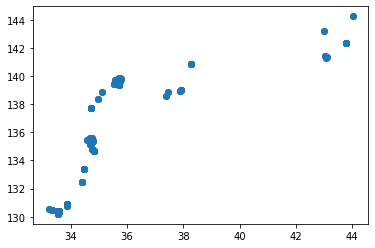

In [18]:
#畫出餐廳所在的經緯度
plt.scatter(train_data.latitude, train_data.longitude)
plt.show()

In [19]:
#確認餐廳的經緯度數量是否正確
train_data.latitude.nunique(), train_data.longitude.nunique()

(108, 108)

In [20]:
air_reserve.tail()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10
92377,air_3cad29d1a23209d2,2017-05-31 21:00:00,2017-04-22 10:00:00,3


In [21]:
#確認測試資料的資料天數
len(pd.date_range("2017-01-01", "2017-05-31"))

151

In [22]:
#將餐廳的地區與類型編碼成數字
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_data['air_genre_name'] = lb.fit_transform(train_data['air_genre_name'])
train_data['air_area_name']  = lb.fit_transform(train_data['air_area_name'])
train_data.head()

,air_store_id,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,3,7,9,-1,21,-1,6,62,35.658068,139.751599
2,air_0241aa3964b7f861,-1,-1,10,9,17,10,-1,5,8,...,9,13,20,1,-1,6,7,82,35.712607,139.779996
3,air_0328696196e46f18,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,17,6,10,-1,-1,4,98,34.701279,135.528090
4,air_034a3d5b40d5b1b1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,6,2,12,14,-1,-1,2,102,34.692337,135.472229


2. 正規化

使用 MinMaxScaler 進行標準化，將訓練數據的最大值設置為 1，最小值設置為 0。

In [23]:
#使用log1p正規化後存在TRdata
def log_transform(data):
    data = data.applymap(lambda x: 0 if x==-1 else x)
    data.iloc[:, 1:367] = np.log1p(data.iloc[:, 1:367])
    return data

TRdata = log_transform(train_data)
TRdata.head(10)
TRdata.head(10)

,air_store_id,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.386294,2.079442,2.302585,0.000000,3.091042,0.000000,6,62,35.658068,139.751599
2,air_0241aa3964b7f861,0.000000,0.0,2.397895,2.302585,2.890372,2.397895,0.000000,1.791759,2.197225,...,2.302585,2.639057,3.044522,0.693147,0.000000,1.945910,7,82,35.712607,139.779996
3,air_0328696196e46f18,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.890372,1.945910,2.397895,0.000000,0.000000,4,98,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.945910,1.098612,2.564949,2.708050,0.000000,0.000000,2,102,34.692337,135.472229
5,air_036d4f1ee7285390,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.258097,2.484907,0.000000,0.000000,0.000000,0.000000,2,31,34.799767,135.360073
6,air_0382c794b73b51ad,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.386294,...,3.332205,3.433987,0.000000,3.367296,3.178054,2.944439,2,68,35.602125,139.671958
7,air_03963426c9312048,0.000000,0.0,0.000000,4.143135,3.433987,3.970292,3.637586,4.499810,4.110874,...,3.806662,3.891820,4.127134,4.304065,4.189655,0.000000,7,15,34.386244,132.455018
8,air_04341b588bde96cd,2.397895,0.0,0.000000,3.178054,3.583519,3.526361,3.970292,3.871201,4.276666,...,3.433987,3.218876,2.772589,3.433987,3.496508,0.000000,7,66,35.735623,139.651658
9,air_049f6d5b402a31b2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.833213,3.135494,2.639057,2.995732,2.890372,1.098612,8,0,33.589216,130.392813


3. 生成 LSTM 的輸入

In [24]:
#定義特徵工程的方法(generate_walkforward_data)
#將資料分成 training dataset 和 validation dataset

from sklearn.model_selection import train_test_split

def generate_walkforward_data(data, input_seq_len, output_seq_len, date_start_col, date_end_col, val_data=0.05):
    date_cols = np.r_[date_start_col: date_end_col]
    train_points = len(date_cols) - input_seq_len - output_seq_len
    input_seqs = []
    output_seqs = []
    for i in range(train_points+1):
        inp_start = i + date_start_col
        inp_end = inp_start + input_seq_len
        out_end = inp_end + output_seq_len 
        input_seqs.append( data.iloc[: , inp_start:inp_end].values.reshape(1, -1, input_seq_len).transpose(0, 2, 1) )
        output_seqs.append( data.iloc[: , inp_end:out_end].values.reshape(1, -1, output_seq_len).transpose(0, 2, 1) )
        
    input_seqs = np.concatenate(input_seqs)
    output_seqs = np.concatenate(output_seqs)
    
    train_x, val_x, train_y, val_y = train_test_split(input_seqs, output_seqs, test_size=val_data, random_state=1126)
    
    return train_x, val_x, train_y, val_y

In [25]:
#將TRdata丟進generate_walkforward_data，生成LSTM的輸入(train_x)
input_seq_len = 151
output_seq_len = 151
train_x, val_x, train_y, val_y = generate_walkforward_data(TRdata, input_seq_len, output_seq_len, 1, 367)
print(train_x, train_y, val_x, val_y)
print(train_x.shape, train_y.shape, val_x.shape, val_y.shape)

[[[0.         0.         2.19722458 ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         2.7080502  ... 0.         0.         0.        ]
  ...
  [3.55534806 0.         0.         ... 2.07944154 3.33220451 1.94591015]
  [3.4657359  0.         1.38629436 ... 2.39789527 3.58351894 1.60943791]
  [3.04452244 0.         2.63905733 ... 3.17805383 2.56494936 1.60943791]]

 [[0.         0.         2.89037176 ... 0.         0.         0.        ]
  [0.         0.         2.39789527 ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         2.39789527 ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         1.94591015 ... 0.         0.         0.        ]]

 [[0.         0.         2.19722458 ... 0.         0.         0.        ]
  [0.         0.      

4. 創建模型

In [26]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [29]:
#定義模型
def buildManyToManyModel(train_data):
    model = Sequential()
    model.add(LSTM(32, input_shape = (train_data.shape[1], train_data.shape[2]),return_sequences=True))
    model.add(TimeDistributed(Dense(821)))
    model.add(Activation('linear'))
    
    for i in range(1,5):
        model.add(LSTM(32, return_sequences=True))
        model.add(TimeDistributed(Dense(821)))
        model.add(Activation('linear'))
    
    #model.add(LSTM(32, return_sequences=True))
    #model.add(TimeDistributed(Dense(821)))
    #model.add(Activation('linear'))
    
    #model.add(LSTM(32, return_sequences=True))
    #model.add(TimeDistributed(Dense(821)))
    #model.add(Activation('linear'))
    
    #model.compile(loss="mse")
    #model.compile(loss="mse", optimizer="rmsprop")
    model.compile(loss="mse", optimizer="adam")
    return model

In [30]:
#將LSTM的輸入(train_x)丟進模型訓練
#印出模型架構
model = buildManyToManyModel(train_x)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 151, 32)           109312    
                                                                 
 time_distributed (TimeDistr  (None, 151, 821)         27093     
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 151, 821)          0         
                                                                 
 lstm_1 (LSTM)               (None, 151, 32)           109312    
                                                                 
 time_distributed_1 (TimeDis  (None, 151, 821)         27093     
 tributed)                                                       
                                                                 
 activation_1 (Activation)   (None, 151, 821)          0

5. 學習

In [31]:
history = model.fit(train_x, train_y, epochs=300, batch_size=50, validation_data=(val_x, val_y))

Epoch 1/300
2/2 [==============================] - 9s 2s/step - loss: 6.7347 - val_loss: 6.6842
Epoch 2/300
2/2 [==============================] - 1s 648ms/step - loss: 6.6940 - val_loss: 6.5627
Epoch 3/300
2/2 [==============================] - 1s 617ms/step - loss: 6.5655 - val_loss: 6.3784
Epoch 4/300
2/2 [==============================] - 1s 667ms/step - loss: 6.3753 - val_loss: 6.1414
Epoch 5/300
2/2 [==============================] - 1s 683ms/step - loss: 6.1325 - val_loss: 5.8432
Epoch 6/300
2/2 [==============================] - 1s 710ms/step - loss: 5.8303 - val_loss: 5.5135
Epoch 7/300
2/2 [==============================] - 1s 619ms/step - loss: 5.5008 - val_loss: 5.1995
Epoch 8/300
2/2 [==============================] - 1s 645ms/step - loss: 5.1892 - val_loss: 4.9171
Epoch 9/300
2/2 [==============================] - 1s 604ms/step - loss: 4.9083 - val_loss: 4.6584
Epoch 10/300
2/2 [==============================] - 1s 569ms/step - loss: 4.6505 - val_loss: 4.4150
Epoch 11/300

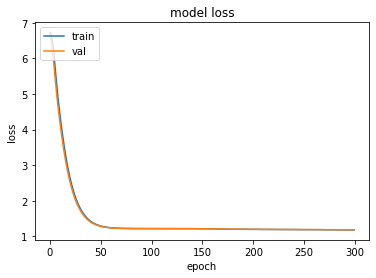

In [34]:
#畫出loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [35]:
#印出Epoch與loss
callback = EarlyStopping(monitor="loss", patience=3, verbose=1, mode="auto")
history = model.fit(train_x, train_y, epochs=1000, batch_size=50, validation_data=(val_x, val_y), callbacks=[callback])

Epoch 1/1000
2/2 [==============================] - 1s 370ms/step - loss: 1.1777 - val_loss: 1.1801
Epoch 2/1000
2/2 [==============================] - 1s 318ms/step - loss: 1.1785 - val_loss: 1.1824
Epoch 3/1000
2/2 [==============================] - 1s 349ms/step - loss: 1.1778 - val_loss: 1.1847
Epoch 4/1000
2/2 [==============================] - 1s 320ms/step - loss: 1.1786 - val_loss: 1.1797
Epoch 4: early stopping


In [39]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


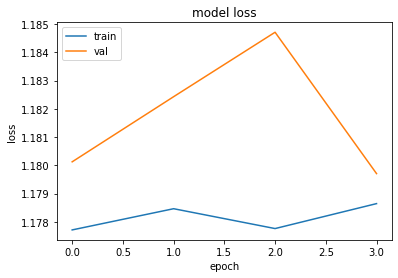

In [40]:
#畫出loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [41]:
#確認測試結果的維度
test_output = model.predict(train_x)
test_output.shape

(61, 151, 821)

In [42]:
#生成last_train_day，使用訓練資料（TRdata）2016年最後的151天，來預測2017年的前151天
train_points = 367 - 151 - 151
date_start_col = 1
inp_start = train_points + date_start_col
inp_end = inp_start + input_seq_len
out_end = inp_end + output_seq_len 
last_train_day = TRdata.iloc[: , inp_end:out_end]
last_train_day

,2016-08-04,2016-08-05,2016-08-06,2016-08-07,2016-08-08,2016-08-09,2016-08-10,2016-08-11,2016-08-12,2016-08-13,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,air_genre_name
0,3.433987,3.761200,2.079442,0.000000,3.332205,3.332205,3.526361,0.000000,0.000000,0.000000,...,0.000000,4.605170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,6
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.397895,2.302585,0.000000,1.386294,2.079442,2.302585,0.000000,3.091042,0.00000,6
2,0.000000,1.791759,2.302585,0.693147,2.397895,2.397895,2.197225,0.000000,0.000000,0.000000,...,1.945910,2.708050,2.484907,2.302585,2.639057,3.044522,0.693147,0.000000,1.94591,7
3,2.302585,0.693147,0.000000,0.000000,2.564949,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.890372,1.945910,2.397895,0.000000,0.00000,4
4,2.302585,2.944439,2.995732,1.791759,1.386294,0.000000,2.302585,2.079442,3.044522,2.302585,...,3.135494,3.135494,2.772589,1.945910,1.098612,2.564949,2.708050,0.000000,0.00000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,2.564949,2.484907,3.135494,1.609438,0.000000,2.708050,2.944439,2.564949,3.295837,3.784190,...,3.044522,3.258097,2.833213,2.397895,3.218876,3.637586,2.772589,0.000000,0.00000,11
817,3.583519,3.465736,3.610918,2.995732,3.555348,3.178054,3.583519,3.401197,3.465736,3.737670,...,0.000000,0.000000,0.000000,3.401197,3.688879,3.610918,3.332205,3.496508,0.00000,6
818,2.397895,2.197225,2.639057,1.945910,2.197225,0.000000,2.302585,3.091042,2.833213,2.708050,...,2.564949,0.000000,2.302585,2.564949,0.000000,2.397895,2.397895,0.693147,0.00000,8
819,3.044522,3.496508,0.000000,0.000000,2.397895,3.433987,3.465736,0.000000,3.044522,0.000000,...,3.465736,1.386294,0.000000,3.367296,2.639057,3.871201,0.000000,0.000000,0.00000,7


In [43]:
#將表格reshape成array
last_train_day = last_train_day.values.reshape(1, -1, output_seq_len).transpose(0, 2, 1)
last_train_day.shape

(1, 151, 821)

In [44]:
last_train_day

array([[[3.4339872 , 0.        , 0.        , ..., 2.39789527,
         3.04452244, 0.        ],
        [3.76120012, 0.        , 1.79175947, ..., 2.19722458,
         3.49650756, 1.38629436],
        [2.07944154, 0.        , 2.30258509, ..., 2.63905733,
         0.        , 2.30258509],
        ...,
        [0.        , 3.09104245, 0.        , ..., 0.69314718,
         0.        , 0.69314718],
        [0.        , 0.        , 1.94591015, ..., 0.        ,
         0.        , 0.        ],
        [6.        , 6.        , 7.        , ..., 8.        ,
         7.        , 1.        ]]])

In [45]:
last_train_day[0]

array([[3.4339872 , 0.        , 0.        , ..., 2.39789527, 3.04452244,
        0.        ],
       [3.76120012, 0.        , 1.79175947, ..., 2.19722458, 3.49650756,
        1.38629436],
       [2.07944154, 0.        , 2.30258509, ..., 2.63905733, 0.        ,
        2.30258509],
       ...,
       [0.        , 3.09104245, 0.        , ..., 0.69314718, 0.        ,
        0.69314718],
       [0.        , 0.        , 1.94591015, ..., 0.        , 0.        ,
        0.        ],
       [6.        , 6.        , 7.        , ..., 8.        , 7.        ,
        1.        ]])

6. 根據學習結果預測訪客數量

In [46]:
#將last_train_day丟入模型預測，確認維度
test_output = model.predict(last_train_day)
test_output.shape

(1, 151, 821)

In [47]:
test_output

array([[[ 1.5189009 , -0.19830918,  1.2402246 , ...,  1.2843363 ,
          1.3746834 ,  0.78419805],
        [ 1.9061478 , -0.24407226,  1.5574664 , ...,  1.6099151 ,
          1.7264652 ,  0.9894314 ],
        [ 1.9746187 , -0.23893002,  1.6098651 , ...,  1.6663451 ,
          1.7887971 ,  1.0285156 ],
        ...,
        [ 2.439421  ,  0.92201525,  1.8357683 , ...,  1.9854548 ,
          2.3131866 ,  1.5369098 ],
        [ 2.4394999 ,  0.9221861 ,  1.835789  , ...,  1.9855055 ,
          2.3132663 ,  1.5369878 ],
        [ 2.439575  ,  0.9223484 ,  1.8358086 , ...,  1.9855536 ,
          2.3133414 ,  1.5370617 ]]], dtype=float32)

In [48]:
#將測試結果編碼回人數
store = np.exp(test_output[0]) - 1
store[:,6]

array([ 5.8535957, 10.15295  , 11.123021 , 11.333346 , 11.419882 ,
       11.485802 , 11.548149 , 11.610156 , 11.672571 , 11.735605 ,
       11.799335 , 11.863778 , 11.928938 , 11.994818 , 12.061395 ,
       12.128654 , 12.19658  , 12.265152 , 12.334348 , 12.404134 ,
       12.474485 , 12.545373 , 12.616764 , 12.688619 , 12.760906 ,
       12.833578 , 12.9066105, 12.9799385, 13.053526 , 13.127328 ,
       13.201282 , 13.275347 , 13.349466 , 13.423592 , 13.497651 ,
       13.571594 , 13.645363 , 13.718894 , 13.792128 , 13.865003 ,
       13.937461 , 14.009435 , 14.080863 , 14.151689 , 14.221849 ,
       14.291287 , 14.359948 , 14.427758 , 14.4946785, 14.560657 ,
       14.625638 , 14.689574 , 14.752413 , 14.814118 , 14.874651 ,
       14.933974 , 14.9920635, 15.048868 , 15.104378 , 15.158571 ,
       15.211414 , 15.2628975, 15.313017 , 15.361755 , 15.409111 ,
       15.455078 , 15.499662 , 15.542862 , 15.58469  , 15.625151 ,
       15.664251 , 15.702034 , 15.7384815, 15.773626 , 15.8075

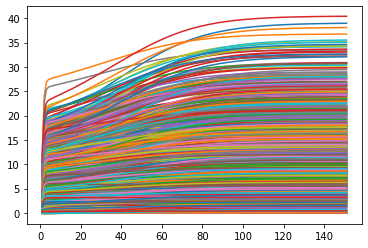

In [49]:
#畫出所有餐廳預測的151天人數分布
people = store[:,]
day = np.arange(1,152)
plt.plot(day,people)

7. 導出到提交文件

In [50]:
visitor = np.exp(test_output[0]) - 1
visitor.shape

(151, 821)

In [51]:
result = visitor.T.ravel()
result.shape

(123971,)

In [52]:
#將預測結果依照ID與日期排序形成表格
datetime = pd.date_range('2017-01-01',periods=151)
string_list = []
for i in range(len(TRdata['air_store_id'])): #821
    for j in range(len(datetime)): #151
        string_list.append(TRdata['air_store_id'][i]+'_'+datetime[j].strftime('%Y-%m-%d'))
        
df = pd.DataFrame(result, index = string_list,columns=['visitors'])
df.index.name = 'id'
df

,visitors
id,
air_00a91d42b08b08d9_2017-01-01,3.567203
air_00a91d42b08b08d9_2017-01-02,5.727125
air_00a91d42b08b08d9_2017-01-03,6.203872
air_00a91d42b08b08d9_2017-01-04,6.319187
air_00a91d42b08b08d9_2017-01-05,6.375702
...,...
air_fff68b929994bfbd_2017-05-27,3.649414
air_fff68b929994bfbd_2017-05-28,3.649816
air_fff68b929994bfbd_2017-05-29,3.650198


In [53]:
#匯出csv
df.to_csv('result.csv')

8. 評估Teat Accuracy

In [54]:
#依照前面同樣步驟處理test dataset

#step1
test_data = pd.DataFrame({'air_store_id': test_air_ids})

#step2
date_cols = pd.date_range(start='2017-01-01', end='2017-05-31').date.astype(str)

for col in date_cols:
    test_data[col] = test_data.air_store_id.apply(lambda x: visit_data_dict[(x, col)] 
                                                    if (x, col) in visit_data_dict.keys()
                                                    else -1).astype(np.int32)
#step3
test_data = pd.merge(test_data, air_info, on='air_store_id', how='left')

#step4
test_data.air_area_name.nunique(),test_data.air_genre_name.nunique()

#step5
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
test_data['air_genre_name'] = lb.fit_transform(test_data['air_genre_name'])
test_data['air_area_name']  = lb.fit_transform(test_data['air_area_name'])

#step6
def log_transform(data):
    data = data.applymap(lambda x: 0 if x==-1 else x)
    data.iloc[:, 1:151] = np.log1p(data.iloc[:, 1:151])
    return data

TESTdata = log_transform(test_data)
TESTdata.head(10)

D:\Users\Selena Huang\temp/ipykernel_18560/2557090178.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[col] = test_data.air_store_id.apply(lambda x: visit_data_dict[(x, col)]


,air_store_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0.000000,0.000000,0.000000,2.890372,3.135494,3.610918,3.091042,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0.000000,0.000000,0.000000,0.000000,1.791759,1.791759,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,6,62,35.658068,139.751599
2,air_0241aa3964b7f861,0.000000,0.000000,0.000000,3.135494,1.945910,1.386294,2.302585,2.079442,1.945910,...,0.0,0.0,0.0,0.0,0.0,0,7,82,35.712607,139.779996
3,air_0328696196e46f18,2.302585,0.000000,0.000000,0.000000,0.000000,1.791759,1.791759,1.098612,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,4,98,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0.000000,0.693147,1.386294,0.693147,1.791759,2.484907,1.791759,1.791759,0.000000,...,0.0,0.0,0.0,0.0,0.0,0,2,102,34.692337,135.472229
5,air_036d4f1ee7285390,0.000000,0.000000,0.000000,0.000000,0.000000,1.945910,3.555348,2.302585,2.484907,...,0.0,0.0,0.0,0.0,0.0,0,2,31,34.799767,135.360073
6,air_0382c794b73b51ad,0.000000,0.000000,0.000000,0.000000,2.564949,3.044522,2.944439,3.091042,3.091042,...,0.0,0.0,0.0,0.0,0.0,0,2,68,35.602125,139.671958
7,air_03963426c9312048,0.000000,0.000000,3.178054,2.302585,1.609438,3.610918,4.043051,1.609438,2.079442,...,0.0,0.0,0.0,0.0,0.0,0,7,15,34.386244,132.455018
8,air_04341b588bde96cd,0.000000,0.000000,0.000000,2.639057,2.995732,4.290459,3.258097,3.583519,4.343805,...,0.0,0.0,0.0,0.0,0.0,0,7,66,35.735623,139.651658
9,air_049f6d5b402a31b2,0.000000,0.000000,0.000000,0.000000,2.484907,2.772589,1.609438,2.890372,1.609438,...,0.0,0.0,0.0,0.0,0.0,0,8,0,33.589216,130.392813


In [55]:
test_y = TESTdata.iloc[:, 1:152]
test_y = test_y.values.reshape(1, -1, output_seq_len).transpose(0, 2, 1)
test_y = test_y[0].T.ravel()
test_y.shape

(123971,)

In [56]:
#將實際結果依照ID與日期排序形成表格
datetime = pd.date_range('2017-01-01',periods=151)
string_list = []
for i in range(len(TESTdata['air_store_id'])): #821
    for j in range(len(datetime)): #151
        string_list.append(TESTdata['air_store_id'][i]+'_'+datetime[j].strftime('%Y-%m-%d'))
        
df = pd.DataFrame(test_y, index = string_list,columns=['visitors'])
df.index.name = 'id'
df

,visitors
id,
air_00a91d42b08b08d9_2017-01-01,0.000000
air_00a91d42b08b08d9_2017-01-02,0.000000
air_00a91d42b08b08d9_2017-01-03,0.000000
air_00a91d42b08b08d9_2017-01-04,2.890372
air_00a91d42b08b08d9_2017-01-05,3.135494
...,...
air_fff68b929994bfbd_2017-05-27,0.000000
air_fff68b929994bfbd_2017-05-28,0.000000
air_fff68b929994bfbd_2017-05-29,0.000000


In [57]:
#處理實際結果
test_y = TESTdata.iloc[:, 1:152]
test_y = test_y.values.reshape(1, -1, output_seq_len).transpose(0, 2, 1)
test_y = test_y[0]
test_y.shape

(151, 821)

In [58]:
#處理預測結果
visitor = visitor.reshape(1, -1, output_seq_len).transpose(0, 2, 1)
visitor = visitor[0]
visitor.shape

(151, 821)

In [59]:
#計算預測結果的MSE test_y為實際資料，visitor為預測結果
from sklearn.metrics import mean_squared_error
print("mean_squared_error:",mean_squared_error(test_y,visitor))

mean_squared_error: 136.45559733021793
